In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import normflows as nf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
import random
from torch.utils.data import DataLoader
import pandas as pd
import openturns as ot
print(f"Using device: {device}")
import pyvinecopulib as pv
from scipy.stats import gaussian_kde
from scipy.stats import gamma
from scipy.stats import expon
from scipy.stats import norm
from GPDFlow import DataTransform
from GPDFlow import T_mGPD_NF

/home/pgrad2/2448355h/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Using device: cuda


In [4]:
dir_out = "/home/pgrad2/2448355h/My_PhD_Project/01_Output/GPDFlow/"


In [4]:
def sim_revexp_T_mgpd(n, d, a, beta, sig, gamma, MGPD=True, std=False):

    E = np.random.exponential(1, n )[:,None]
    T_total = []
    for j in range(d):
        U = np.random.uniform(0, 1, n)
        T = a[j]*np.log(U) - beta[j]
        T_total.append(T)
    T_total = np.column_stack(T_total)

    S = T_total - np.max(T_total, axis=1)[:,None]
    Z = E + S 

    if std and not MGPD:
        return Z

    X = []
    for j in range(d):
        if gamma[j] != 0:
            X.append(sig[j] * (np.exp(Z[:, j] * gamma[j]) - 1) / gamma[j])
        else:
            X.append(sig[j] * Z[:, j])
    X = np.column_stack(X)

    if MGPD and not std:
        return X
    if std and MGPD:
        return {'X': X, 'Z': Z}

In [13]:
n_samples = 100
n_experiments = 100    
d = 2
a = np.array([2,0.5,1, 5,1.5])
beta = np.array([1, 2,3,4,5])
sig = np.array([0.5, 1.2, 1, 1.5, 0.8])
gamma = np.array([-0.1, 0.2, 0, 0.15, -0.05])

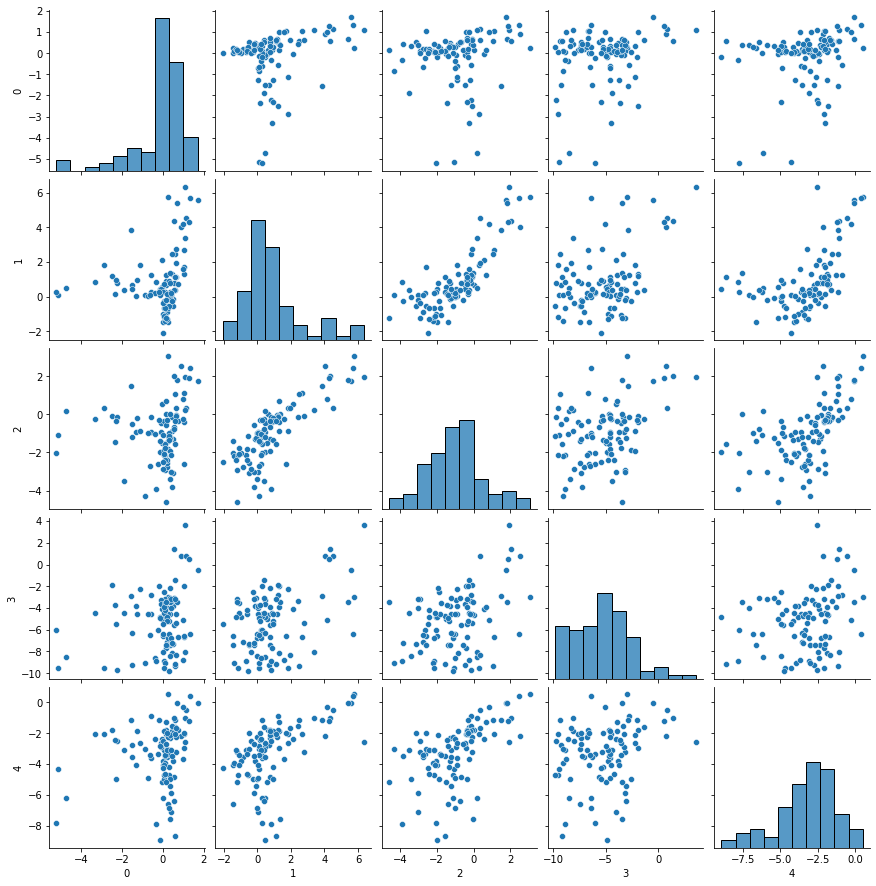

In [5]:
samples = sim_revexp_T_mgpd(n_samples, 5, a, beta, sig, gamma)

# samples = sim_revexp_T_mgpd(n_samples, 2, a[3:], beta[3:], sig[3:], gamma[3:])
sns.pairplot(pd.DataFrame(samples), diag_kws={'bins': 10})

In [6]:
dim = 3
base = nf.distributions.DiagGaussian(dim)


num_layers = 16
torch.manual_seed(0)

latent_size = dim
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(num_layers):
    s = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]


f_T_model = nf.NormalizingFlow(base, flows)
f_T_model = f_T_model.to(device)

batch_size = 64
loss_history = []
epochs = 200

model = T_mGPD_NF(dim=dim, flow =f_T_model, device=device, s_min=-10,
                  s_max = 10, num_integration_points=1000, penalty_lambda=10000, fix_margin=False)

optimizer = torch.optim.Adam([
    {'params': model.flow_model.parameters(), 'lr': 1e-2},  # Flow layers
    {'params': model.data_transform.log_sigma, 'lr': 1e-1},  # Faster for log_sigma
    {'params': model.data_transform.theta, 'lr': 1e-1}       # Faster for gamma
], weight_decay = 1e-5 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

for i in range(n_experiments):
    

    samples = sim_revexp_T_mgpd(n_samples, dim, a, beta, sig, gamma)

    data = torch.tensor(samples, dtype=torch.float, device = device)

    memory = torch.cuda.memory_allocated(device) /10**9

    Training_Data = DataLoader(data, batch_size=batch_size, shuffle=True)
    torch.autograd.set_detect_anomaly(True)

    for epoch in range(epochs):
        epoch_loss = 0.0
        
        for x_data in Training_Data:
            # Sample a batch of data from h_U

            batch_loss = model(x_data)

            # Backpropagation
            optimizer.zero_grad()
            batch_loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            # Record loss
            loss_history.append(batch_loss.item())
            epoch_loss += batch_loss.item()

            if torch.isnan(batch_loss) or torch.isinf(batch_loss):
                print("NaN or Inf detected!")
                break

        # Debugging: Print shapes
        scheduler.step()
    torch.save(model.state_dict(), dir_out + f'model_{dim}D_100_{i}.pt')
    print(f"Completed Experiment {i} \n")



Completed Experiment 0 

Completed Experiment 1 

Completed Experiment 2 

Completed Experiment 3 

Completed Experiment 4 

Completed Experiment 5 

Completed Experiment 6 

Completed Experiment 7 

Completed Experiment 8 

Completed Experiment 9 

Completed Experiment 10 

Completed Experiment 11 

Completed Experiment 12 

Completed Experiment 13 

Completed Experiment 14 

Completed Experiment 15 

Completed Experiment 16 

Completed Experiment 17 

Completed Experiment 18 

Completed Experiment 19 

Completed Experiment 20 

Completed Experiment 21 

Completed Experiment 22 

Completed Experiment 23 

Completed Experiment 24 

Completed Experiment 25 

Completed Experiment 26 

Completed Experiment 27 

Completed Experiment 28 

Completed Experiment 29 

Completed Experiment 30 

Completed Experiment 31 

Completed Experiment 32 

Completed Experiment 33 

Completed Experiment 34 

Completed Experiment 35 

Completed Experiment 36 

Completed Experiment 37 

Completed Experiment 3

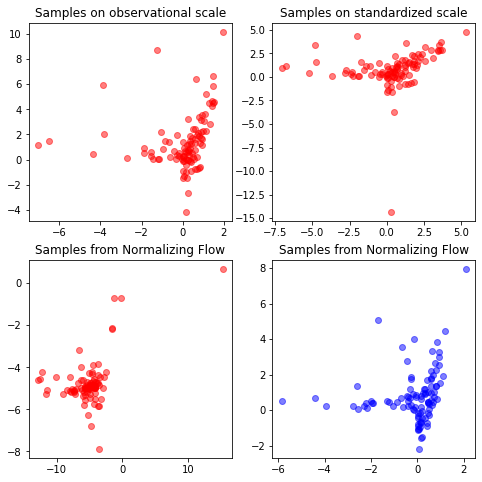

In [7]:
samples_obs, samples_std, samples_T= model.sample(n_samples)
samples = sim_revexp_T_mgpd(n_samples, d, a, beta, sig, gamma)
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.scatter(samples_obs[:,0].cpu().data.numpy(), samples_obs[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples on observational scale')
plt.subplot(2, 2, 2)
plt.scatter(samples_std[:,0].cpu().data.numpy(), samples_std[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples on standardized scale')
plt.subplot(2, 2, 3)
plt.scatter(samples_T[:,0].cpu().data.numpy(), samples_T[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples from Normalizing Flow')
plt.subplot(2, 2, 4)
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, color='blue')
plt.title('Samples from Normalizing Flow')
plt.show()

In [8]:
print(sig)
print(model.data_transform.get_sigma())
print(gamma)
print(model.data_transform.get_gamma())

[0.5 1.2 1.  1.5 0.8]
tensor([0.5375, 1.0820, 0.9102, 1.1614, 0.7523], device='cuda:0',
       grad_fn=<ClampBackward1>)
[-0.1   0.2   0.    0.15 -0.05]
tensor([-0.1588,  0.2564,  0.0349,  0.0811, -0.0224], device='cuda:0',
       grad_fn=<MulBackward0>)


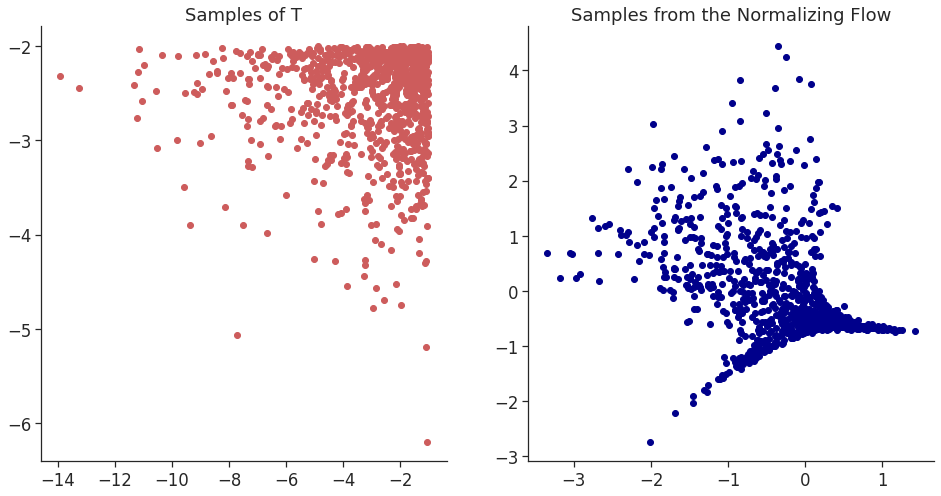

In [38]:
seed = 1234
n = 1000
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

T_total = []
for j in range(d):
    U = np.random.uniform(0, 1, n)
    T = a[j]*np.log(U) - beta[j]
    T_total.append(T)
T_total = np.column_stack(T_total)

model = GPDFlow(2)

sns.set(style="ticks",font_scale=1.5)
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.scatter(T_total[:,0], T_total[:,1], alpha=1, color='indianred')
model.load_state_dict(torch.load(dir_out + f'model_{2}D_100_{0}.pt', weights_only=True))
model.eval()
samples_obs, samples_std, samples_T= model.sample(n)
plt.title('Samples of T')

plt.subplot(1, 2, 2)
plt.scatter(samples_T[:,0].cpu().data.numpy(), samples_T[:,1].cpu().data.numpy(), alpha=1, color='darkblue')
plt.title('Samples from the Normalizing Flow')

# model.load_state_dict(torch.load(dir_out + f'model_{2}D_100_{2}.pt', weights_only=True))
# model.eval()
# samples_obs, samples_std, samples_T= model.sample(n)
# plt.subplot(1, 3, 3)
# plt.scatter(samples_T[:,0].cpu().data.numpy(), samples_T[:,1].cpu().data.numpy(), alpha=1, color='darkblue')
# plt.title('Samples from the Normalizing Flow')

sns.despine()
plt.savefig(dir_out + 'Plots/'+'f_T_sample.pdf',bbox_inches='tight')
plt.show()

In [10]:
def chi_theorical(alpha1, alpha2):
    if alpha1 <= 0 or alpha2 <= 0:
        raise ValueError("alpha1 and alpha2 must be greater than 0")
    
    # Identify alpha_(1) = max(alpha1, alpha2) and alpha_(2) = min(alpha1, alpha2)
    alpha_max = max(alpha1, alpha2)
    alpha_min = min(alpha1, alpha2)
    
    # Calculate the components of the formula
    term1 = (1 + 1 / alpha_max) / (1 + 1 / alpha_min)
    term1_power = term1 ** (1 + alpha_min)
    term2 = (alpha_max / alpha_min) * (1 / (1 + alpha1 + alpha2))
    
    # Final chi value
    chi = 1 - term1_power * term2
    return chi

def pairwise_chi_theorical(alpha_vector):
    n = len(alpha_vector)
    chi_dict = {}
    
    for i in range(n-1):
        for j in range(i+1,n):
            chi_dict[f"{i+1}-{j+1}"] =  chi_theorical(alpha_vector[i], alpha_vector[j])
    
    return chi_dict

In [14]:
chi_values_theorical = pairwise_chi_theorical(1/a)
chi_values_theorical


{'1-2': 0.5959389821791157,
 '1-3': 0.5645351568385462,
 '1-4': 0.3598892916940263,
 '1-5': 0.5318610619613964,
 '2-3': 0.71875,
 '2-4': 0.40792321620687566,
 '2-5': 0.6507777482864301,
 '3-4': 0.39186245321194657,
 '3-5': 0.612201755794261,
 '4-5': 0.3754625539543247}

In [2]:
def empirical_upper_tail_dependence(X, p):

    # Compute the quantiles
    quantile = np.quantile(X, p, axis = 0)
    
    # Count joint exceedances
    joint_exceedance = np.sum((X[:,0] > quantile[0]) & (X[:,1] > quantile[1]))
    exceedance_X1 = np.sum(X[:,0] > quantile[0])
    
    # Calculate lambda_u
    if exceedance_X1 == 0:  # Avoid division by zero
        return 0.0
    chi_u = joint_exceedance / exceedance_X1
    return chi_u


def pairwise_chi_empirical(dim, model, n_monte_carlo, n_experiments):
    probs = np.linspace(0.80, 0.99, 100)
    # Compute lambda_u for each quantile
    sample_chi = {}
    for i in range(dim-1):
        for j in range(i+1,dim):
            chi_values = []
            for _ in range(n_experiments):  # Step 3: Repeat 200 times
                model.load_state_dict(torch.load(dir_out + f'model_{dim}D_100_{_}.pt', weights_only=True))
                model.eval()
                samples_obs, samples_std, samples_T= model.sample(n_monte_carlo)
                sampled_data = samples_obs.cpu().data.numpy()
                chi_values.append(empirical_upper_tail_dependence(sampled_data[:,[i,j]], 0.99))
            sample_chi[f"{i+1}-{j+1}"] =  chi_values
    
    return sample_chi


def GPDFlow(dim):
    base = nf.distributions.DiagGaussian(dim)

    num_layers = 16
    torch.manual_seed(0)

    latent_size = dim
    b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
    flows = []
    for i in range(num_layers):
        s = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
        t = nf.nets.MLP([latent_size, 4 * latent_size, latent_size], init_zeros=True, output_fn='tanh')
        if i % 2 == 0:
            flows += [nf.flows.MaskedAffineFlow(b, t, s)]
        else:
            flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
        flows += [nf.flows.ActNorm(latent_size)]


    f_T_model = nf.NormalizingFlow(base, flows)
    f_T_model = f_T_model.to(device)



    model = T_mGPD_NF(dim=dim, flow =f_T_model, device=device, s_min=-10,
                    s_max = 10, num_integration_points=1000, penalty_lambda=10000, fix_margin=False)
    return model

In [5]:
model = GPDFlow(2)
chi_values_empipical_2 = pairwise_chi_empirical(dim=2, model=model,  n_monte_carlo=10000, n_experiments=100)
model = GPDFlow(3)
chi_values_empipical_3 = pairwise_chi_empirical(dim=3, model=model,  n_monte_carlo=10000, n_experiments=100)
model = GPDFlow(5)
chi_values_empipical_5 = pairwise_chi_empirical(dim=5, model=model,  n_monte_carlo=10000, n_experiments=100)

In [50]:
chi_values_empipical_5

{'1-2': [0.54,
  0.65,
  0.51,
  0.46,
  0.57,
  0.62,
  0.67,
  0.65,
  0.58,
  0.49,
  0.59,
  0.58,
  0.64,
  0.43,
  0.64,
  0.65,
  0.68,
  0.65,
  0.69,
  0.53,
  0.56,
  0.6,
  0.65,
  0.63,
  0.61,
  0.59,
  0.58,
  0.47,
  0.65,
  0.64,
  0.68,
  0.56,
  0.64,
  0.59,
  0.51,
  0.51,
  0.66,
  0.58,
  0.64,
  0.71,
  0.63,
  0.65,
  0.66,
  0.54,
  0.55,
  0.32,
  0.53,
  0.58,
  0.59,
  0.62,
  0.69,
  0.64,
  0.47,
  0.59,
  0.6,
  0.53,
  0.7,
  0.59,
  0.54,
  0.57,
  0.63,
  0.58,
  0.61,
  0.57,
  0.58,
  0.57,
  0.56,
  0.62,
  0.33,
  0.45,
  0.73,
  0.6,
  0.68,
  0.4,
  0.54,
  0.5,
  0.61,
  0.53,
  0.56,
  0.65,
  0.54,
  0.48,
  0.58,
  0.66,
  0.54,
  0.56,
  0.61,
  0.55,
  0.56,
  0.73,
  0.56,
  0.66,
  0.64,
  0.58,
  0.56,
  0.57,
  0.68,
  0.6,
  0.68,
  0.5],
 '1-3': [0.56,
  0.52,
  0.5,
  0.44,
  0.54,
  0.56,
  0.53,
  0.61,
  0.6,
  0.36,
  0.54,
  0.45,
  0.68,
  0.49,
  0.51,
  0.53,
  0.61,
  0.59,
  0.59,
  0.43,
  0.44,
  0.56,
  0.59,
  0.63,
  0

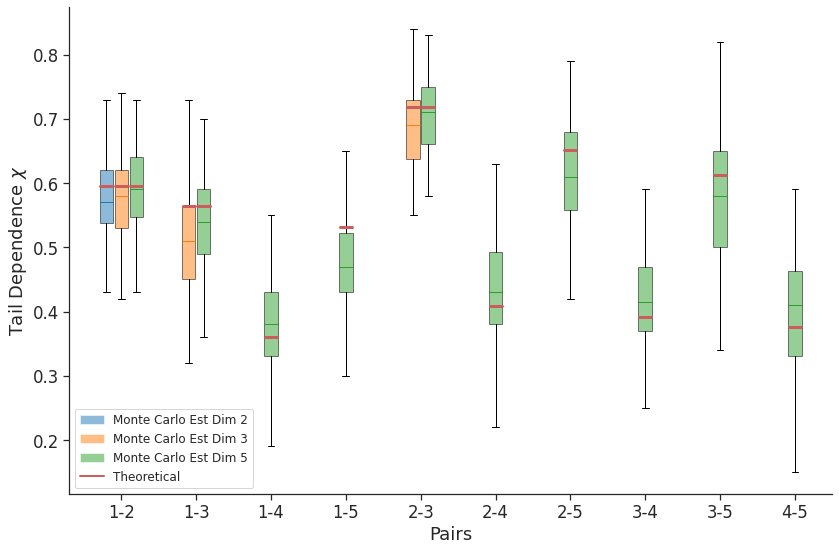

In [43]:
pairs = ['1-2', '1-3', '1-4', '1-5', '2-3', '2-4', '2-5', '3-4', '3-5', '4-5']

# Use the keys from the 5-dimensional dictionary as the full set of pairs.
all_keys = sorted(chi_values_empipical_5.keys())  # sorted in lexicographical order; adjust as needed
x_positions = np.arange(len(all_keys))

delta = 0.2  # spacing factor for box positions

sns.set(style="ticks", font_scale=1.5)
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare a mapping from each key to a list of tuples (dimension, data)
# We use all_keys as the base so that the x-axis remains consistent.
data_by_key = {key: [] for key in all_keys}
for dim, chi_dict in [(2, chi_values_empipical_2),
                      (3, chi_values_empipical_3),
                      (5, chi_values_empipical_5)]:
    for key, data in chi_dict.items():
        if key in data_by_key:
            data_by_key[key].append((dim, data))

colors = {2: '#1f77b4', 3: '#ff7f0e', 5: '#2ca02c'}
alpha_value = 0.5

# Loop over each key and plot the boxplots for the dimensions available.
for i, key in enumerate(all_keys):
    # Sort by dimension to maintain a consistent order (2, then 3, then 5)
    items = sorted(data_by_key[key], key=lambda x: x[0])
    n = len(items)
    if n == 0:
        continue  
    # Compute offsets so that the available boxplots are centered.
    offsets = [ (j - (n-1)/2) * delta for j in range(n) ]
    # Plot each available boxplot at the computed offset
    for offset, (dim, data) in zip(offsets, items):
        pos = x_positions[i] + offset
        bp = ax.boxplot(data, positions=[pos], widths=0.18,
                        patch_artist=True, showfliers=False)
        for patch in bp['boxes']:
            patch.set_facecolor(colors[dim])
            patch.set_alpha(alpha_value)
        for median in bp['medians']:
            median.set_color(colors[dim])
        # Plot the theoretical line if available.
        if key in chi_values_theorical:
            theory_val = chi_values_theorical[key]
            ax.plot([pos - 0.08, pos + 0.08],
                    [theory_val, theory_val],
                    color='indianred', lw=3)

# Set x-axis labels.
ax.set_xticks(x_positions)
ax.set_xticklabels(all_keys)
ax.set_xlabel("Pairs")
ax.set_ylabel(r"Tail Dependence $\chi$")

# Add legend.
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[dim], label=f'Monte Carlo Est Dim {dim}', alpha=alpha_value) for dim in [2, 3, 5]]
legend_elements.append(plt.Line2D([0], [0], color='indianred', lw=2, label='Theoretical'))
ax.legend(handles=legend_elements, loc='lower left',fontsize=12)
sns.despine()
plt.tight_layout()
plt.savefig(dir_out + 'Plots/'+f'Simulation_1_chi.pdf',bbox_inches='tight')
plt.show()

In [ ]:
def marginal_parameter_monte_carlo(dim):
    

    sigma_dict = {f'{i+1}': [] for i in range(dim)}
    gamma_dict = {f'{i+1}': [] for i in range(dim)}

    for _ in range(n_experiments):  # Step 3: Repeat 200 times
        model.load_state_dict(torch.load(dir_out + f'model_{dim}D_100_{_}.pt', weights_only=True))
        model.eval()
        sigma_hat = model.data_transform.get_sigma().cpu().data.numpy()
        gamma_hat = model.data_transform.get_gamma().cpu().data.numpy()
        for i in range(dim):
            sigma_dict[f'{i+1}'].append(sigma_hat[i])
            gamma_dict[f'{i+1}'].append(gamma_hat[i])
    return sigma_dict, gamma_dict


model = GPDFlow(2)
sigma_dict_2, gamma_dict_2 = marginal_parameter_monte_carlo(2)
model = GPDFlow(3)
sigma_dict_3, gamma_dict_3 = marginal_parameter_monte_carlo(3)
model = GPDFlow(5)
sigma_dict_5, gamma_dict_5 = marginal_parameter_monte_carlo(5)

In [21]:
sigma_true = dict(zip(['1', '2', '3', '4', '5'], sig))
gamma_true = dict(zip(['1', '2', '3', '4', '5'], gamma))

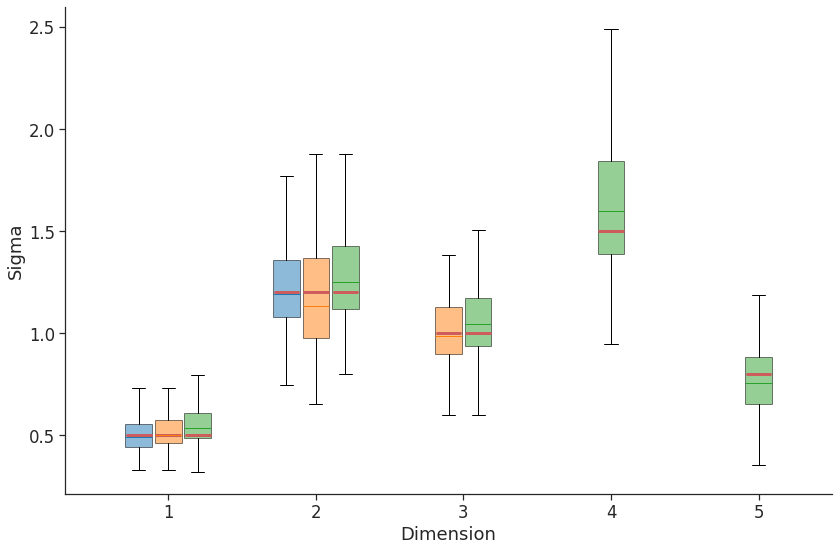

In [44]:
pairs = ['1', '2', '3', '4', '5']

# Use the keys from the 5-dimensional dictionary as the full set of pairs.
all_keys = sorted(sigma_dict_5.keys())  
x_positions = np.arange(len(all_keys))

delta = 0.2  # spacing factor for box positions

sns.set(style="ticks", font_scale=1.5)
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare a mapping from each key to a list of tuples (dimension, data)
# We use all_keys as the base so that the x-axis remains consistent.
data_by_key = {key: [] for key in all_keys}
for dim, chi_dict in [(2, sigma_dict_2),
                      (3, sigma_dict_3),
                      (5, sigma_dict_5)]:
    for key, data in chi_dict.items():
        if key in data_by_key:
            data_by_key[key].append((dim, data))

colors = {2: '#1f77b4', 3: '#ff7f0e', 5: '#2ca02c'}
alpha_value = 0.5

# Loop over each key and plot the boxplots for the dimensions available.
for i, key in enumerate(all_keys):
    # Sort by dimension to maintain a consistent order (2, then 3, then 5)
    items = sorted(data_by_key[key], key=lambda x: x[0])
    n = len(items)
    if n == 0:
        continue 
    # Compute offsets so that the available boxplots are centered.
    offsets = [ (j - (n-1)/2) * delta for j in range(n) ]
    # Plot each available boxplot at the computed offset
    for offset, (dim, data) in zip(offsets, items):
        pos = x_positions[i] + offset
        bp = ax.boxplot(data, positions=[pos], widths=0.18,
                        patch_artist=True, showfliers=False)
        for patch in bp['boxes']:
            patch.set_facecolor(colors[dim])
            patch.set_alpha(alpha_value)
        for median in bp['medians']:
            median.set_color(colors[dim])
        # Plot the theoretical line if available.
        if key in sigma_true:
            theory_val = sigma_true[key]
            ax.plot([pos - 0.08, pos + 0.08],
                    [theory_val, theory_val],
                    color='indianred', lw=3)

# Set x-axis labels.
ax.set_xticks(x_positions)
ax.set_xticklabels(all_keys)
ax.set_xlabel("Dimension")
ax.set_ylabel("Sigma")
# ax.set_title("Empirical Tail Dependence Boxplots with Theoretical Lines")

# Add legend.
# from matplotlib.patches import Patch
# legend_elements = [Patch(facecolor=colors[dim], label=f'Monte Calro Results in Dim {dim}', alpha=alpha_value) for dim in [2, 3, 5]]
# legend_elements.append(plt.Line2D([0], [0], color='darkorange', lw=2, label='Theoretical'))
# ax.legend(handles=legend_elements, loc='best',fontsize=15)
sns.despine()
plt.tight_layout()
plt.savefig(dir_out + 'Plots/'+f'Simulation_1_sigma.pdf',bbox_inches='tight')
plt.show()

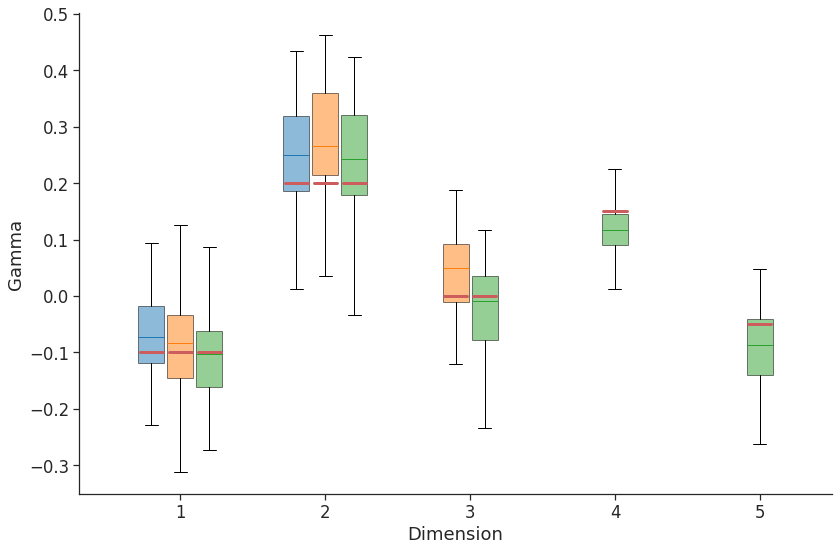

In [45]:
pairs = ['1', '2', '3', '4', '5']

# Use the keys from the 5-dimensional dictionary as the full set of pairs.
all_keys = sorted(gamma_dict_5.keys())  
x_positions = np.arange(len(all_keys))

delta = 0.2  # spacing factor for box positions

sns.set(style="ticks", font_scale=1.5)
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare a mapping from each key to a list of tuples (dimension, data)
# We use all_keys as the base so that the x-axis remains consistent.
data_by_key = {key: [] for key in all_keys}
for dim, chi_dict in [(2, gamma_dict_2),
                      (3, gamma_dict_3),
                      (5, gamma_dict_5)]:
    for key, data in chi_dict.items():
        if key in data_by_key:
            data_by_key[key].append((dim, data))

colors = {2: '#1f77b4', 3: '#ff7f0e', 5: '#2ca02c'}
alpha_value = 0.5

# Loop over each key and plot the boxplots for the dimensions available.
for i, key in enumerate(all_keys):
    # Sort by dimension to maintain a consistent order (2, then 3, then 5)
    items = sorted(data_by_key[key], key=lambda x: x[0])
    n = len(items)
    if n == 0:
        continue 
    # Compute offsets so that the available boxplots are centered.
    offsets = [ (j - (n-1)/2) * delta for j in range(n) ]
    # Plot each available boxplot at the computed offset
    for offset, (dim, data) in zip(offsets, items):
        pos = x_positions[i] + offset
        bp = ax.boxplot(data, positions=[pos], widths=0.18,
                        patch_artist=True, showfliers=False)
        for patch in bp['boxes']:
            patch.set_facecolor(colors[dim])
            patch.set_alpha(alpha_value)
        for median in bp['medians']:
            median.set_color(colors[dim])
        # Plot the theoretical line if available.
        if key in gamma_true:
            theory_val = gamma_true[key]
            ax.plot([pos - 0.08, pos + 0.08],
                    [theory_val, theory_val],
                    color='indianred', lw=3)
                
# Set x-axis labels.
ax.set_xticks(x_positions)
ax.set_xticklabels(all_keys)
ax.set_xlabel("Dimension")
ax.set_ylabel("Gamma")
# ax.set_title("Empirical Tail Dependence Boxplots with Theoretical Lines")

# Add legend.
# from matplotlib.patches import Patch
# legend_elements = [Patch(facecolor=colors[dim], label=f'Monte Calro Results in Dim {dim}', alpha=alpha_value) for dim in [2, 3, 5]]
# legend_elements.append(plt.Line2D([0], [0], color='darkorange', lw=2, label='Theoretical'))
# ax.legend(handles=legend_elements, loc='best',fontsize=15)
sns.despine()
plt.tight_layout()
plt.savefig(dir_out + 'Plots/'+f'Simulation_1_gamma.pdf',bbox_inches='tight')
plt.show()